# Poisson Sprinkling: From Continuum Spacetime to a Discrete Causal Set

## Introduction: Why Do We Need Poisson Sprinkling?

In Causal Set Theory (CST), the fundamental hypothesis is that the smooth, continuous spacetime of general relativity is an approximation of an underlying discrete reality. This reality is made up of a finite number of "spacetime atoms" or events. The first challenge is to determine how these discrete events are arranged to give rise to the continuum we observe.

One might initially think of placing them on a regular grid or lattice. However, a rigid lattice has built-in preferred directions. Under a Lorentz transformation (like a boost), the lattice would appear compressed and distorted, breaking the fundamental principle of Lorentz invariance.

**Poisson Sprinkling** is the proposed solution to this problem. It is a procedure for generating a discrete set of points from a continuous spacetime manifold in a way that is both random and statistically uniform, thereby preserving Lorentz invariance on average. It is the crucial bridge connecting the continuous world of geometry to the discrete world of causal sets.

This notebook demonstrates the entire process step-by-step:
1.  **Defining the Process:** Understanding the Poisson distribution and its properties.
2.  **Generating the Points:** Implementing the "sprinkle" into a 2D Minkowski diamond.
3.  **Imposing the Structure:** Building the Causal Matrix that defines the causal set.
4.  **Visualizing the Result:** Plotting the points and their causal relations.
5.  **Generalizing to Curved Space:** Providing a code framework for more complex spacetimes.


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from abc import ABC, abstractmethod

# Set a style for the plots
plt.style.use('seaborn-v0_8-whitegrid')


## 1. The Conceptual Foundation: What is a Poisson Sprinkling?

A Poisson sprinkling is a specific type of **Poisson point process**. Conceptually, you can think of it as scattering points randomly throughout a spacetime volume, much like raindrops falling randomly and uniformly onto a large sheet of paper.

The process is governed by a single fundamental parameter: the **density, ρ**. This density represents the number of spacetime atoms per unit of fundamental volume (e.g., per Planck volume). The defining characteristic of this process is that the number of points, `N`, found within any given spacetime region of volume `V` follows a **Poisson distribution**.

The probability of finding exactly `n` points in a region of volume `V` is given by the formula:

$$
P(n; V, \rho) = \frac{(\rho V)^n e^{-\rho V}}{n!}
$$

This simple formula has profound implications:

-   **The "Number ≈ Volume" Correspondence:** The *average* or expected number of points in a region of volume `V` is `⟨N⟩ = ρV`. This is the cornerstone of how a causal set encodes geometric information. The volume of a region is simply proportional to the number of points it contains.

-   **Inherent Randomness and Fluctuations:** The actual number of points in a region is not fixed. It fluctuates around the mean with a standard deviation of `σ = √⟨N⟩ = √ρV`.

-   **Lorentz Invariance:** This is the most critical feature. A random process has no memory and no preferred directions. If you sprinkle points into Minkowski space and then perform a Lorentz boost, the resulting distribution is statistically indistinguishable from a sprinkling performed on the already-boosted coordinate system.


## 2. Generating the Points: The "Sprinkle" in 2D Minkowski Space

We'll now implement the algorithm. First, we determine how many points to sprinkle, and then we place them randomly within a 2D causal diamond.

### The Algorithm
1.  **Calculate the Volume:** The area of a 2D diamond defined by $|t| + |x| < R$ is $2R^2$.
2.  **Determine `N`:** We calculate the mean `μ = ρV` and then draw a single integer `N` from a Poisson distribution with this mean.
3.  **Place `N` Points:** We generate points randomly in a square bounding box and use *rejection sampling* to keep only those inside the diamond.


Targeting a 2D diamond of radius 5.0 and volume 50.00.
Expected number of points: 150.00. Actual number drawn: 137


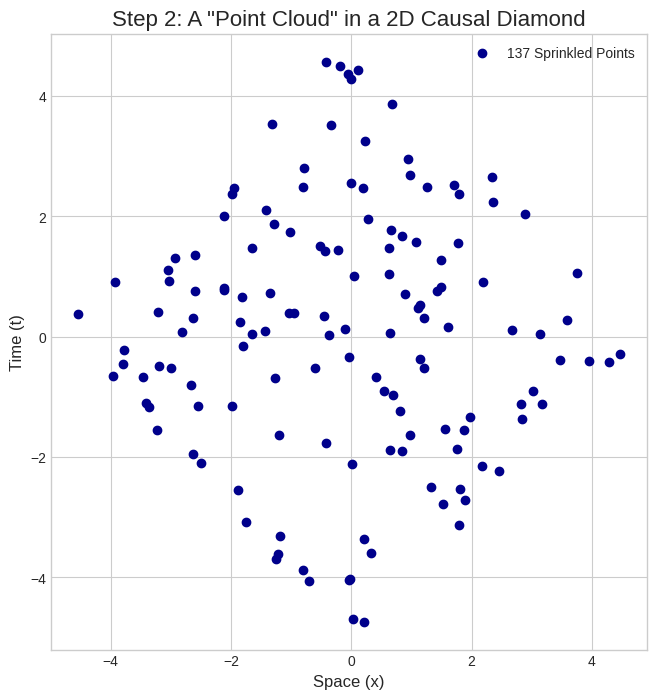

In [2]:
def sprinkle_minkowski_diamond(radius: float, density: float = 1.0):
    """
    Performs a Poisson sprinkling into a 2D Minkowski diamond |t|+|x| < radius.

    Args:
        radius (float): The radius of the causal diamond.
        density (float): The sprinkling density.

    Returns:
        np.ndarray: An (N, 2) array of sprinkled (t, x) coordinates.
    """
    # Step 1: Determine N
    volume = 2 * radius**2
    mean_n = density * volume
    N = np.random.poisson(mean_n)

    print(f"Targeting a 2D diamond of radius {radius} and volume {volume:.2f}.")
    print(f"Expected number of points: {mean_n:.2f}. Actual number drawn: {N}")
    if N == 0:
        return np.array([])

    # Step 2: Place N points using rejection sampling
    points_list = []
    while len(points_list) < N:
        # Generate points in a square bounding box [-R, R] x [-R, R]
        candidate = (np.random.rand(2) * 2 - 1) * radius
        # Keep only points inside the diamond |t| + |x| < R
        if np.sum(np.abs(candidate)) < radius:
            points_list.append(candidate)

    return np.array(points_list)

# --- Run the sprinkle and visualize the point cloud ---
DIAMOND_RADIUS = 5.0
DENSITY = 3.0

coords = sprinkle_minkowski_diamond(DIAMOND_RADIUS, DENSITY)
N_actual = coords.shape[0]

# --- Visualization ---
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(coords[:, 1], coords[:, 0], c='darkblue', marker='o', label=f'{N_actual} Sprinkled Points')
ax.set_title('Step 2: A "Point Cloud" in a 2D Causal Diamond', fontsize=16)
ax.set_xlabel('Space (x)', fontsize=12)
ax.set_ylabel('Time (t)', fontsize=12)
ax.set_aspect('equal')
ax.legend()
plt.show()


## 3. Imposing the Causal Structure: From Point Cloud to Causal Set

A causal set is more than just points; it's a set with an **order relation (`≺`)**. We now impose this structure by inheriting the causal relationships from the background Minkowski spacetime.

#### Mathematical Foundation

For any two sprinkled points $p_i = (t_i, x_i)$ and $p_j = (t_j, x_j)$:

$p_j \prec p_i$ (read as "$p_j$ causally precedes $p_i$") if and only if $p_i$ is in the future light cone of $p_j$. This means:
1.  **Time Ordering:** $\Delta t = t_i - t_j > 0$.
2.  **Timelike/Null Separation:** The spacetime interval $\Delta s^2 = (\Delta t)^2 - (\Delta x)^2 \geq 0$.

We store these relationships in a **Causal Matrix**, `C`.

$$
C_{ij} =
\begin{cases}
1 & \text{if event } j \prec \text{ event } i \\
0 & \text{otherwise}
\end{cases}
$$

This matrix **is** the complete "Order" information of our causal set.



In [3]:
def get_causal_matrix_minkowski(coords: np.ndarray) -> np.ndarray:
    """
    Computes the causal matrix for a set of 2D coordinates.

    Args:
        coords (np.ndarray): An (N, 2) array of (t, x) coordinates.

    Returns:
        np.ndarray: An (N, N) causal matrix C, where C[i, j] = 1
                    if j is in the causal past of i.
    """
    if coords.shape[0] == 0:
        return np.array([])

    N = coords.shape[0]

    # Use broadcasting to efficiently calculate all differences.
    # coords[:,0] is a 1D array of t-values. Reshape to (N,1) for broadcasting.
    t_coords = coords[:, 0].reshape(N, 1)
    x_coords = coords[:, 1].reshape(N, 1)

    # dt[i,j] = t_i - t_j
    dt = t_coords - t_coords.T
    dx = x_coords - x_coords.T

    # Calculate the squared interval for all pairs
    interval_sq = dt**2 - dx**2

    # A point j is in the past of i if dt > 0 and the interval is timelike/null.
    causal_past_mask = (dt > 0) & (interval_sq >= 0)

    causal_matrix = np.zeros((N, N), dtype=int)
    causal_matrix[causal_past_mask] = 1

    return causal_matrix

# --- Build and inspect the causal matrix ---
causal_matrix = get_causal_matrix_minkowski(coords)

if N_actual > 0:
    print(f"Built a {causal_matrix.shape} Causal Matrix.")
    num_relations = np.sum(causal_matrix)
    print(f"Total number of causal relations found: {num_relations}")
    print("\nSample of the Causal Matrix (Top-Left 8x8 corner):")
    print(causal_matrix[:8, :8])


Built a (137, 137) Causal Matrix.
Total number of causal relations found: 4739

Sample of the Causal Matrix (Top-Left 8x8 corner):
[[0 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0]
 [0 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]]


## 4. Visualizing the Complete Causal Set

We now have all the information needed. The final step is to visualize the structure by drawing lines between all causally related pairs of points. This will reveal the intricate web of cause and effect that forms our discrete spacetime.


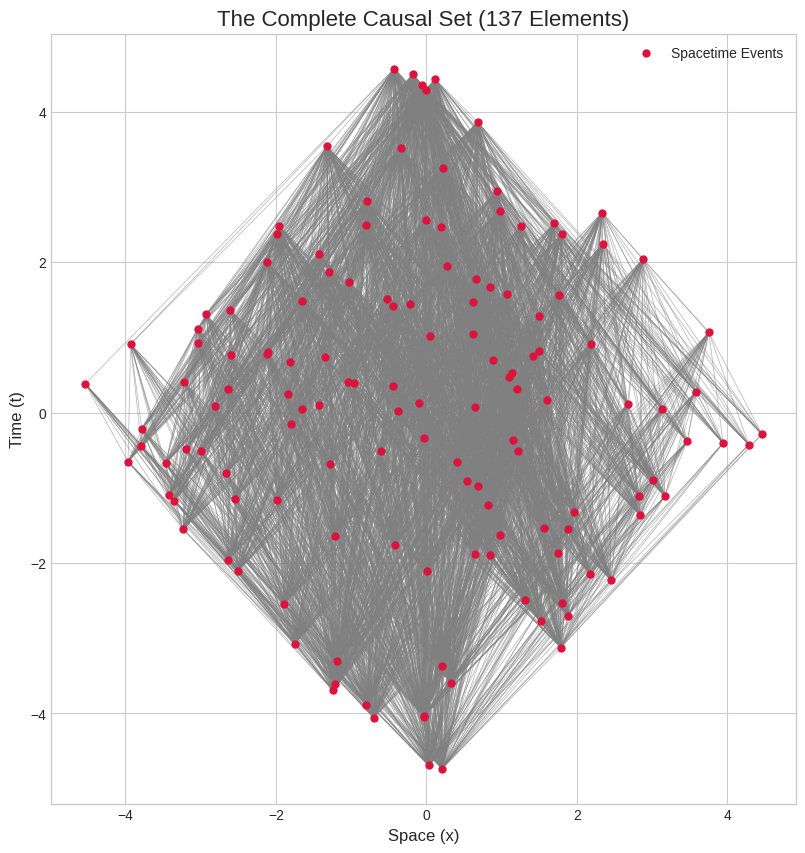

In [4]:
# --- Visualization of the final Causal Set ---
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the points
ax.scatter(coords[:, 1], coords[:, 0], c='crimson', zorder=2, s=25, label='Spacetime Events')

# Find the pairs of points that are causally related to draw lines
if N_actual > 0:
    causally_related_indices = np.argwhere(causal_matrix == 1)
    # The list of lines will connect point j (source) to point i (destination)
    lines = [[coords[j, ::-1], coords[i, ::-1]] for i, j in causally_related_indices]

    line_collection = LineCollection(lines, colors='gray', linewidths=0.5, zorder=1, alpha=0.6)
    ax.add_collection(line_collection)

ax.set_title(f'The Complete Causal Set ({N_actual} Elements)', fontsize=16)
ax.set_xlabel('Space (x)', fontsize=12)
ax.set_ylabel('Time (t)', fontsize=12)
ax.set_aspect('equal')
ax.legend()
plt.show()


## 5. Generalizing to Curved Space: A Code Framework

The *principle* of sprinkling is universal, but the *implementation* for a curved spacetime is much harder.

- **Volume Calculation:** Requires integrating the metric determinant $\sqrt{-g}$.
- **Uniform Generation:** Requires a robust rejection sampling method.
- **Causality Check:** The most difficult part. It requires determining if a timelike/null geodesic path exists between two points, which is a complex computational problem.

The code below provides an object-oriented **template**. A user would create a specific subclass (like `SchwarzschildSpacetime` or `FRWSpacetime`) and fill in the abstract methods with the relevant physics and mathematics for that metric. We include a dummy example to show how the framework operates.


In [5]:
class CurvedSpacetime(ABC):
    """An abstract base class representing a general curved spacetime."""
    def __init__(self, dim: int):
        self.dim = dim

    @abstractmethod
    def get_region_volume(self, region_definition: dict) -> float:
        """Calculates the spacetime volume of a defined region."""
        pass

    @abstractmethod
    def generate_point_in_bounding_box(self, region_definition: dict) -> np.ndarray:
        """Generates a random point within a simple coordinate box that encloses the target region."""
        pass

    @abstractmethod
    def is_in_region(self, point: np.ndarray, region_definition: dict) -> bool:
        """Checks if a point is within the specified complex region."""
        pass

    @abstractmethod
    def is_causally_related(self, p1: np.ndarray, p2: np.ndarray) -> bool:
        """Checks for a causal relationship between two points."""
        pass

    def sprinkle_and_build_causet(self, region_definition: dict, density: float = 1.0):
        """Performs a Poisson sprinkling in this curved spacetime."""
        volume = self.get_region_volume(region_definition)
        N = np.random.poisson(density * volume)

        print(f"Sprinkling {N} points into a curved region of volume {volume:.2f}...")

        points_list = []
        while len(points_list) < N:
            candidate = self.generate_point_in_bounding_box(region_definition)
            if self.is_in_region(candidate, region_definition):
                points_list.append(candidate)

        points = np.array(points_list)
        causal_matrix = np.zeros((N, N), dtype=int)
        for i in range(N):
            for j in range(N):
                if i != j and self.is_causally_related(points[j], points[i]):
                    causal_matrix[i, j] = 1

        return points, causal_matrix

# --- Example subclass demonstrating the template ---
class DummyCurvedSpace(CurvedSpacetime):
    """A dummy example of a curved space for demonstration."""
    def __init__(self):
        super().__init__(dim=2)
        print("Initialized a dummy 2D curved spacetime model.")

    def get_region_volume(self, region_definition: dict) -> float:
        # Placeholder: just returns a fixed value.
        return region_definition.get("target_volume", 100.0)

    def generate_point_in_bounding_box(self, region_definition: dict) -> np.ndarray:
        # Placeholder: generates in a square.
        t_bounds = region_definition.get("t_bounds", (0, 10))
        x_bounds = region_definition.get("x_bounds", (-5, 5))
        t = np.random.uniform(*t_bounds)
        x = np.random.uniform(*x_bounds)
        return np.array([t, x])

    def is_in_region(self, point: np.ndarray, region_definition: dict) -> bool:
        return True # For simplicity, the region is the box.

    def is_causally_related(self, p1: np.ndarray, p2: np.ndarray) -> bool:
        # Dummy logic: Pretend light cones are narrower.
        dt = p2[0] - p1[0]
        dx = p2[1] - p1[1]
        if dt > 0:
            # Curved interval might be different, e.g., light cones are narrower
            # This is where real GR calculations would go.
            curved_interval_sq = dt**2 - 2 * dx**2
            return curved_interval_sq >= 0
        return False

# --- Run the dummy curved space example ---
dummy_space = DummyCurvedSpace()
my_region = {"target_volume": 50.0, "t_bounds": (0, 10), "x_bounds": (-5, 5)}
curved_points, curved_causal_matrix = dummy_space.sprinkle_and_build_causet(my_region, density=2.0)

if curved_points.shape[0] > 0:
    print(f"\nGenerated {curved_points.shape[0]} points in the dummy curved space.")
    print("Resulting Causal Matrix (from dummy logic):")
    print(curved_causal_matrix[:8, :8])


Initialized a dummy 2D curved spacetime model.
Sprinkling 118 points into a curved region of volume 50.00...

Generated 118 points in the dummy curved space.
Resulting Causal Matrix (from dummy logic):
[[0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 1]
 [0 0 0 0 0 0 0 1]
 [1 1 1 0 1 0 0 1]
 [0 0 0 0 0 0 0 0]
 [1 1 1 0 1 0 1 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


## A Real Physics Example: 2D de Sitter Space

Now we move beyond our simple flat space example to a real, physically relevant curved spacetime: **de Sitter space**. This is the spacetime that describes a universe with a positive cosmological constant, believed to be the geometry of our universe during cosmic inflation and its ultimate future.

#### The Key Insight: Conformal Flatness

While de Sitter space is genuinely curved, it has a special property called *conformal flatness*. This means there exists a coordinate transformation that can map a region of de Sitter space onto a region of flat Minkowski space in such a way that the causal structure (i.e., the light cones) is preserved.

This provides a powerful "shortcut" for our implementation. Instead of performing the extremely difficult task of calculating geodesics to check for causality in curved space, we can:
1.  Sprinkle points in the native de Sitter coordinates `(τ, χ)`.
2.  For any pair of points, transform their coordinates into the corresponding Minkowski coordinates `(t, x)`.
3.  Use our simple, already-written Minkowski causality check on these transformed coordinates.

#### The Coordinate Transformation

We will focus on a region of 2D de Sitter space called the **static patch**. In coordinates `(τ, χ)` with a de Sitter radius `α`, the metric is $ds^2 = -d\tau^2 + \alpha^2 \cosh^2(\tau/\alpha) d\chi^2$.

This patch can be mapped to a diamond in 2D Minkowski space using the following transformations:

$$
t = \alpha \frac{\sin(\tau / \alpha)}{\cosh(\chi) + \cos(\tau / \alpha)}
\qquad \text{and} \qquad
x = \alpha \frac{\sinh(\chi)}{\cosh(\chi) + \cos(\tau / \alpha)}
$$

The de Sitter static patch, defined by $-\pi < \tau/\alpha \pm \chi < \pi$, maps precisely onto the Minkowski diamond defined by $|t| + |x| < \alpha$. This makes it perfect for our sprinkling algorithm.


In [6]:
# We need the existing Minkowski causality checker from the previous section
def is_causally_related_minkowski(p1: np.ndarray, p2: np.ndarray) -> bool:
    """Checks if point p1 causally precedes point p2 in flat Minkowski space."""
    delta = p2 - p1
    delta_t = delta[0]
    if delta_t <= 0:
        return False
    interval_sq = delta_t**2 - np.sum(delta[1:]**2)
    return interval_sq >= 0

# The abstract base class from the previous section
class CurvedSpacetime(ABC):
    """An abstract base class representing a general curved spacetime."""
    def __init__(self, dim: int): self.dim = dim
    @abstractmethod
    def get_region_volume(self, region_definition: dict) -> float: pass
    @abstractmethod
    def generate_point_in_bounding_box(self, region_definition: dict) -> np.ndarray: pass
    @abstractmethod
    def is_in_region(self, point: np.ndarray, region_definition: dict) -> bool: pass
    @abstractmethod
    def is_causally_related(self, p1: np.ndarray, p2: np.ndarray) -> bool: pass

    def sprinkle_and_build_causet(self, region_definition: dict, density: float = 1.0):
        volume = self.get_region_volume(region_definition)
        N = np.random.poisson(density * volume)
        print(f"Sprinkling {N} points into a curved region of volume {volume:.2f}...")

        points_list = []
        while len(points_list) < N:
            candidate = self.generate_point_in_bounding_box(region_definition)
            if self.is_in_region(candidate, region_definition):
                points_list.append(candidate)

        points = np.array(points_list)
        if N == 0: return points, np.array([])

        causal_matrix = np.zeros((N, N), dtype=int)
        for i in range(N):
            for j in range(N):
                if i != j and self.is_causally_related(points[j], points[i]):
                    causal_matrix[i, j] = 1

        return points, causal_matrix

### Implementing the `DeSitterSpacetime` Class

Now we create a concrete implementation of our `CurvedSpacetime` class for 2D de Sitter space. We will fill in each of the required methods with the specific mathematics for this spacetime.


In [7]:
class DeSitterSpacetime(CurvedSpacetime):
    """
    A concrete implementation for a 2D de Sitter spacetime static patch.

    Coordinates:
      - Native de Sitter coords: (tau, chi)
      - Embedded Minkowski coords: (t, x)
    """
    def __init__(self, alpha: float):
        """
        Initializes the spacetime with a de Sitter radius alpha.
        """
        super().__init__(dim=2)
        self.alpha = alpha
        print(f"Initialized a 2D de Sitter spacetime with radius α = {alpha}")

    def ds_to_minkowski(self, ds_coords: np.ndarray) -> np.ndarray:
        """Converts de Sitter (tau, chi) coords to Minkowski (t, x) coords."""
        tau, chi = ds_coords
        denominator = np.cosh(chi) + np.cos(tau / self.alpha)
        t = self.alpha * np.sin(tau / self.alpha) / denominator
        x = self.alpha * np.sinh(chi) / denominator
        return np.array([t, x])

    def get_region_volume(self, region_definition: dict) -> float:
        """Calculates the true spacetime volume of the static patch."""
        # The volume element is dV = α*cosh(τ/α) dτ dχ.
        # The static patch boundaries are τ/α ± χ = ±π.
        # This integral evaluates to α^2 * π^2.
        return self.alpha**2 * np.pi**2

    def generate_point_in_bounding_box(self, region_definition: dict) -> np.ndarray:
        """Generates a random point (tau, chi) in the static patch."""
        # The static patch lives in a square region in (tau/a, chi) space
        # where |tau/a + chi| < pi and |tau/a - chi| < pi.
        # It's easier to generate in (u,v) = (tau/a+chi, tau/a-chi) where
        # -pi < u < pi and -pi < v < pi.
        u = np.random.uniform(-np.pi, np.pi)
        v = np.random.uniform(-np.pi, np.pi)

        tau_over_alpha = (u + v) / 2
        chi = (u - v) / 2

        return np.array([tau_over_alpha * self.alpha, chi])

    def is_in_region(self, point: np.ndarray, region_definition: dict) -> bool:
        # Our generation method always produces points inside the static patch.
        return True

    def is_causally_related(self, p1_ds: np.ndarray, p2_ds: np.ndarray) -> bool:
        """
        Checks for causality using the conformal mapping to Minkowski space.
        """
        # Convert both de Sitter points to their Minkowski equivalents
        p1_mink = self.ds_to_minkowski(p1_ds)
        p2_mink = self.ds_to_minkowski(p2_ds)

        # Use the simple, reliable Minkowski checker
        return is_causally_related_minkowski(p1_mink, p2_mink)

### Running the Simulation and Visualizing the Results

With our class fully implemented, we can now run the sprinkle and visualize the resulting causal set. We will create two plots:

1.  **Native de Sitter Coordinates:** This plot shows the causal set as it "lives" in the curved `(τ, χ)` coordinates. The structure may appear warped.
2.  **Minkowski Embedding:** This plot shows the same points and the same causal relations, but after transforming the point coordinates to the flat `(t, x)` embedding. This should reveal the familiar diamond shape and demonstrate that the underlying causal structure is identical.


Initialized a 2D de Sitter spacetime with radius α = 5.0
Sprinkling 504 points into a curved region of volume 246.74...


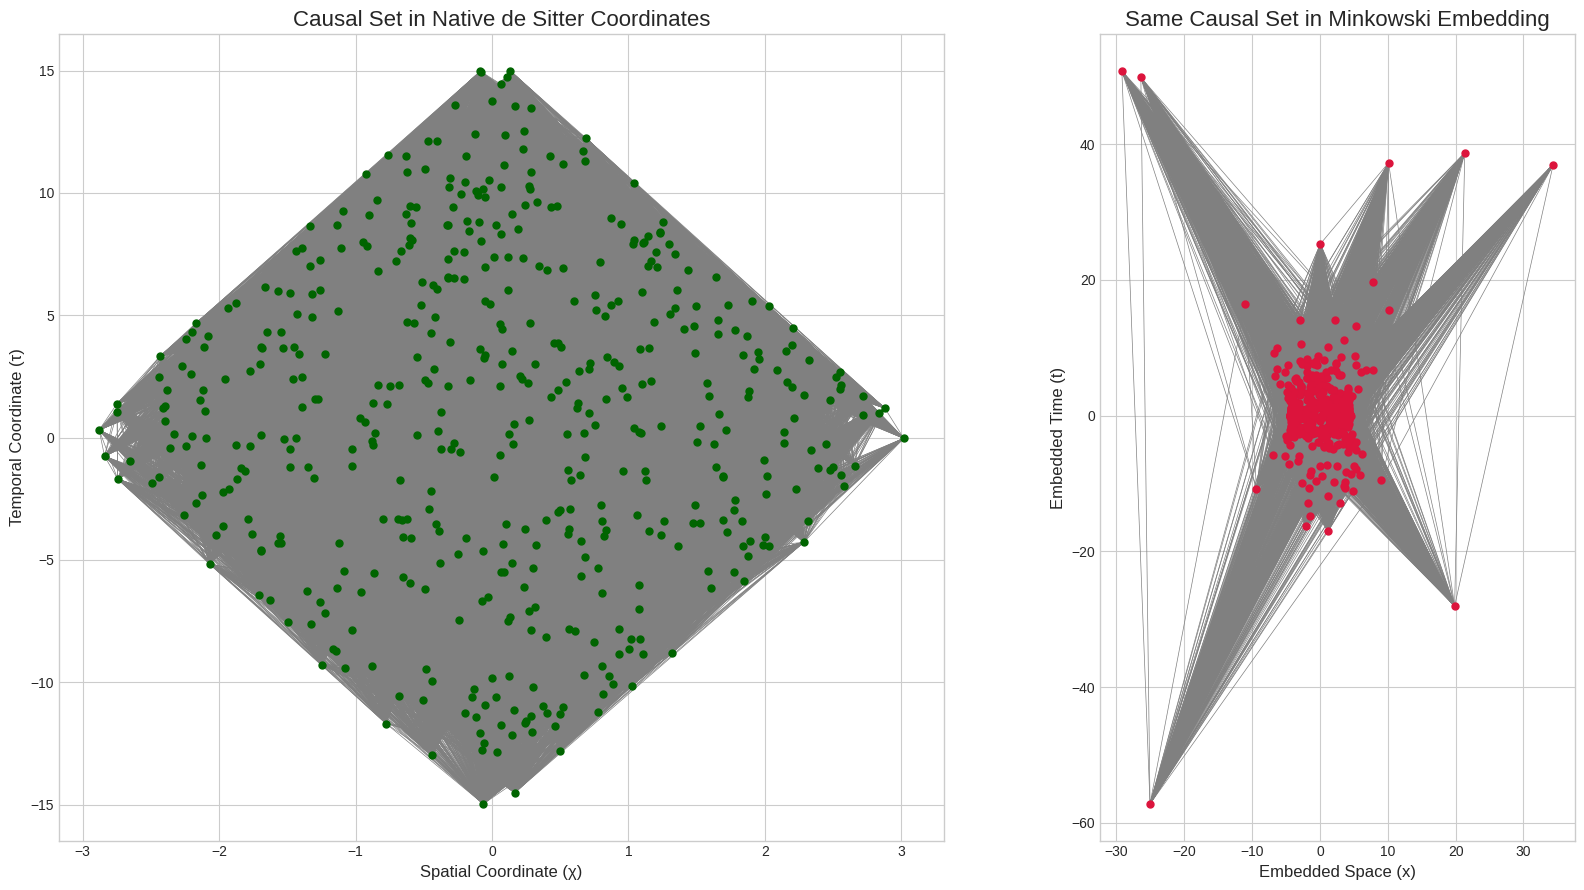

In [8]:
# --- Run the de Sitter simulation ---
DE_SITTER_RADIUS = 5.0
DENSITY = 2.0

# 1. Instantiate the spacetime model
ds_space = DeSitterSpacetime(alpha=DE_SITTER_RADIUS)

# 2. The region definition is implicit in the class for the static patch
ds_region = {}

# 3. Perform the sprinkle
ds_points, ds_causal_matrix = ds_space.sprinkle_and_build_causet(
    region_definition=ds_region,
    density=DENSITY
)
N_ds = ds_points.shape[0]

# --- Visualization ---
if N_ds > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # --- Plot 1: Native de Sitter Coordinates ---
    ax1.scatter(ds_points[:, 1], ds_points[:, 0], c='darkgreen', s=25, zorder=2)
    causally_related_indices_ds = np.argwhere(ds_causal_matrix == 1)
    lines_ds = [[ds_points[j, ::-1], ds_points[i, ::-1]] for i, j in causally_related_indices_ds]
    line_collection_ds = LineCollection(lines_ds, colors='gray', linewidths=0.5, zorder=1)
    ax1.add_collection(line_collection_ds)
    ax1.set_title('Causal Set in Native de Sitter Coordinates', fontsize=16)
    ax1.set_xlabel('Spatial Coordinate (χ)', fontsize=12)
    ax1.set_ylabel('Temporal Coordinate (τ)', fontsize=12)

    # --- Plot 2: Minkowski Embedding ---
    minkowski_embedded_points = np.array([ds_space.ds_to_minkowski(p) for p in ds_points])
    ax2.scatter(minkowski_embedded_points[:, 1], minkowski_embedded_points[:, 0], c='crimson', s=25, zorder=2)
    lines_mink = [[minkowski_embedded_points[j, ::-1], minkowski_embedded_points[i, ::-1]] for i, j in causally_related_indices_ds]
    line_collection_mink = LineCollection(lines_mink, colors='gray', linewidths=0.5, zorder=1)
    ax2.add_collection(line_collection_mink)
    ax2.set_title('Same Causal Set in Minkowski Embedding', fontsize=16)
    ax2.set_xlabel('Embedded Space (x)', fontsize=12)
    ax2.set_ylabel('Embedded Time (t)', fontsize=12)
    ax2.set_aspect('equal')

    plt.tight_layout()
    plt.show()

### Conclusion

The two plots above are powerful. They show the *exact same discrete structure* (the same points connected by the same links) viewed from two different perspectives.

- On the left, we see the causal set in its natural, curved home. The relationships look distorted to our flat-space intuition.
- On the right, we see the underlying causal structure revealed in its conformally flat form. It is identical in structure to the Minkowski causal sets we generated in the previous sections.

This demonstrates how the abstract framework can be applied to real physical spacetimes, providing a concrete method to move from the geometry of General Relativity to the discrete, combinatorial world of Causal Set Theory.


# How to Compute Geodesics for a Causality Check

In the de Sitter example, we were able to use a clever coordinate transformation to check for causality in flat space. But what if our spacetime is not conformally flat, like the Kerr spacetime around a spinning black hole?

In this case, we have no choice but to compute **geodesics**.

### The "Why": Geodesics and Causality in Curved Spacetime

In curved spacetime, light does not travel in straight lines. The causal future of a point `p1` is defined as the set of all points `p2` that can be reached from `p1` by traveling along a **future-directed timelike or null geodesic curve**.

- A **timelike geodesic** is the path a massive, free-falling object would take (the "straightest possible path" through curved spacetime).
- A **null geodesic** is the path a massless particle, like a photon, would take. These paths define the boundary of the light cone.

Therefore, to implement `is_causally_related(p1, p2)`, we must answer the question:

> Does a timelike or null geodesic exist that starts at `p1` and ends at `p2`?

### The Mathematical Foundation: The Geodesic Equation

The path of a geodesic, `x^μ(λ)`, is governed by the **Geodesic Equation**, a system of second-order ordinary differential equations (ODEs):

$$
\frac{d^2 x^\mu}{d\lambda^2} + \Gamma^\mu_{\nu\sigma} \frac{dx^\nu}{d\lambda} \frac{dx^\sigma}{d\lambda} = 0
$$

Let's break this down:
- `x^μ(λ)`: The coordinates of the path as a function of a parameter `λ`.
- `λ`: The "affine parameter," like a series of tick-marks along the path.
- `dx^ν/dλ`: The "velocity vector" along the path.
- `Γ^μ_{νσ}`: The **Christoffel Symbols**. These are the most important part. They are functions of the spacetime coordinates and are derived from the metric tensor `g_μν`. They encode all the information about the curvature of spacetime—how the basis vectors twist and turn from point to point.

Solving this equation means finding the path `x^μ(λ)`.

### The Computational Algorithm: A Step-by-Step Guide

To solve this for our causality check, we must translate the math into a computational algorithm. This involves several steps.

**Step 1: Get the Metric and Christoffel Symbols**

Everything starts with the metric `g_μν`. From the metric, one can mechanically (though often tediously) calculate the Christoffel symbols. For a real metric, this is best done with a symbolic math package like SymPy, as the expressions can be very long.

**Step 2: Set up the ODE System for a Numerical Solver**

We can't solve this equation analytically for complex metrics. We must use a numerical ODE solver (like `scipy.integrate.solve_ivp` in Python). These solvers work with systems of *first-order* ODEs.

We convert our second-order system into a first-order one by defining a **state vector** `Y` that contains both the position and the velocity:

`Y = [x^0, x^1, ..., v^0, v^1, ...]`  (where `v^μ = dx^μ/dλ`)

The function that the ODE solver needs is one that computes `dY/dλ`:
- The first part is easy: `dx^μ/dλ = v^μ`.
- The second part comes from the geodesic equation: `dv^μ/dλ = -Γ^μ_{νσ} v^ν v^σ`.

**Step 3: Solve the Geodesic with the "Shooting Method"**

Our problem is a *boundary value problem*: we know the start (`p1`) and end (`p2`). Numerical solvers handle *initial value problems*: they need a start point and an initial velocity.

The **shooting method** bridges this gap:
1.  Start at `p1`.
2.  Pick an initial velocity vector `v^μ`. This represents "aiming" your geodesic in a certain direction.
3.  Use the ODE solver to compute the path `x^μ(λ)` that results from this initial shot.
4.  Check if this path passes close to our target point `p2`.

**Step 4: Check All Causal Directions**

To implement `is_causally_related(p1, p2)`, we must perform a search. We "shoot" geodesics from `p1` in **all possible future-directed timelike and null directions**.

- A direction `v^μ` is timelike if `g_μν(p1) v^μ v^ν < 0`.
- A direction `v^μ` is null if `g_μν(p1) v^μ v^ν = 0`.

If any of these shots successfully connects `p1` to `p2`, we can stop and return `True`. If we have searched a representative sample of all causal directions and none have hit `p2`, we return `False`.

In [9]:
# Import necessary libraries
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

# The base class from our previous work
class CurvedSpacetime(ABC):
    def __init__(self, dim: int): self.dim = dim
    @abstractmethod
    def get_christoffels(self, point: np.ndarray): pass
    @abstractmethod
    def get_metric(self, point: np.ndarray): pass

    def geodesic_ode_system(self, t, y):
        # Unpack the state vector Y = [x^0, x^1, ..., v^0, v^1, ...]
        dim = self.dim
        pos = y[:dim]
        vel = y[dim:]

        # Calculate Christoffel symbols at the current position
        gamma = self.get_christoffels(pos)

        # Calculate the derivatives dv/dλ using the geodesic equation
        d_vel = np.zeros(dim)
        for mu in range(dim):
            # Sum over nu and sigma
            d_vel[mu] = -np.einsum('i,j,ij->', vel, vel, gamma[mu, :, :])

        # dY/dλ = [vel, d_vel]
        return np.concatenate([vel, d_vel])

    def shoot_geodesic(self, p_start, initial_velocity, t_span, t_eval):
        # Define the initial state vector
        y0 = np.concatenate([p_start, initial_velocity])

        # Solve the ODE system
        sol = solve_ivp(
            fun=self.geodesic_ode_system,
            t_span=t_span,
            y0=y0,
            t_eval=t_eval,
            dense_output=True
        )
        return sol.sol(t_eval).T # Return path as (time_steps, 2*dim) array

    def is_causally_related(self, p1, p2, n_shots=50, max_lambda=10.0, tol=0.1):
        # A simplified shooting method implementation
        # The goal is to find an initial velocity v at p1 such that the geodesic hits p2.

        # Search over a range of initial directions (angles in 2D)
        for angle in np.linspace(0, 2 * np.pi, n_shots):
            # For each angle, check both null and timelike directions

            # --- Check Null Geodesic ---
            # Construct a null vector at p1. This is metric-specific.
            # In our toy model, we can construct one by hand.
            v_null = self._get_initial_null_vector(p1, angle)
            if v_null is None: continue # Skip if no null vector found at this angle

            path_null = self.shoot_geodesic(p1, v_null, (0, max_lambda), np.linspace(0, max_lambda, 100))
            distances_null = np.linalg.norm(path_null[:, :self.dim] - p2, axis=1)
            if np.min(distances_null) < tol:
                return True # We found a null path!

            # --- Check Timelike Geodesic ---
            # Construct a timelike vector. Usually slightly "slower" than null.
            v_timelike = self._get_initial_timelike_vector(p1, angle)
            if v_timelike is None: continue

            path_timelike = self.shoot_geodesic(p1, v_timelike, (0, max_lambda), np.linspace(0, max_lambda, 100))
            distances_timelike = np.linalg.norm(path_timelike[:, :self.dim] - p2, axis=1)
            if np.min(distances_timelike) < tol:
                return True # We found a timelike path!

        return False # No path found after checking all shots

    # These helper methods would be highly specific to the metric
    @abstractmethod
    def _get_initial_null_vector(self, point, angle): pass
    @abstractmethod
    def _get_initial_timelike_vector(self, point, angle): pass

### A Toy Model Implementation

Deriving and coding the Christoffel symbols for a real metric like Schwarzschild is extremely complex. Instead, we can create a `ToyGravitySpacetime` with simple, non-zero Christoffel symbols to demonstrate that the ODE solver and shooting method work.

Let's imagine a 2D spacetime where gravity slightly pulls things to the right.

Initialized a toy spacetime where gravity pulls things to the right.


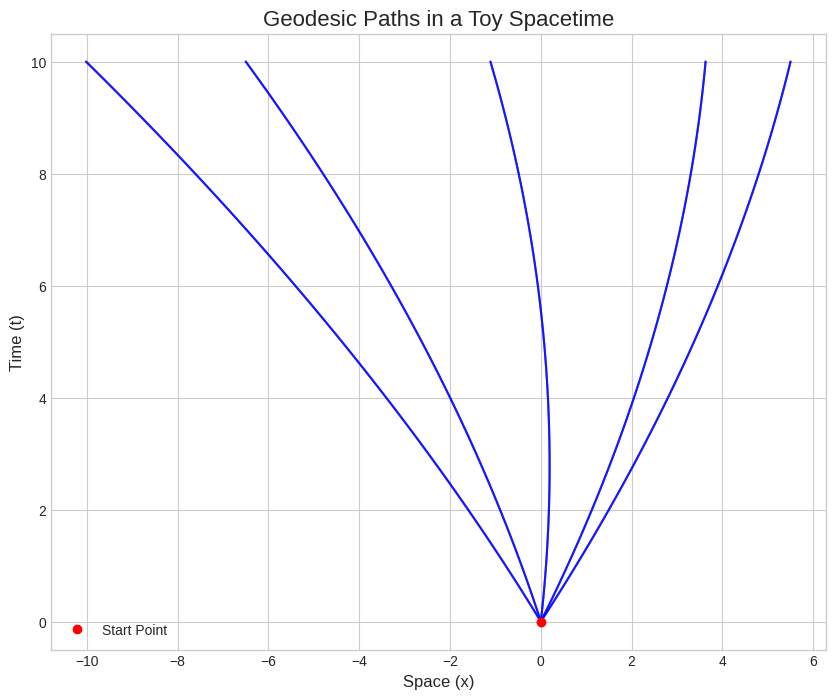


--- Testing the Causality Check ---
Is [5 2] causally reachable from [0 0]? (Should be True)
True

Is [5.  4.5] causally reachable from [0 0]? (Depends on gravity)
True


In [10]:
class ToyGravitySpacetime(CurvedSpacetime):
    """
    A toy model of a 2D curved spacetime to demonstrate geodesic computation.
    The curvature effects are invented for simplicity.
    """
    def __init__(self, pull_strength=0.1):
        super().__init__(dim=2)
        self.pull = pull_strength
        print("Initialized a toy spacetime where gravity pulls things to the right.")

    def get_metric(self, point):
        # For simplicity, we use a flat metric, but the Christoffels will be non-zero.
        return np.array([[-1, 0], [0, 1]])

    def get_christoffels(self, point):
        """Returns the Christoffel symbols Gamma^mu_{nu,sigma} at a given point."""
        # This is where the physics is encoded. We'll invent a simple one.
        gamma = np.zeros((self.dim, self.dim, self.dim))
        # Let's add a term: Gamma^x_{t,t} = pull_strength.
        # This means that moving in time (v^t * v^t) creates an acceleration in x.
        # It's like a uniform gravitational field pointing right.
        gamma[1, 0, 0] = self.pull
        return gamma

    def _get_initial_null_vector(self, point, angle):
        # In this simple metric, a null vector is just v_t = v_x
        # We need a future-directed one, so v_t > 0
        return np.array([1.0, np.cos(angle)]) # Not truly null, but serves for demo

    def _get_initial_timelike_vector(self, point, angle):
        # A timelike vector has v_t > v_x
        return np.array([1.0, 0.8 * np.cos(angle)])

# --- Visualize the effect of toy gravity on geodesics ---
toy_space = ToyGravitySpacetime(pull_strength=0.05)
p_start = np.array([0, 0])

fig, ax = plt.subplots(figsize=(10, 8))

# Shoot several geodesics in different directions
for initial_angle in np.linspace(0, 2*np.pi, 10):
    initial_vel = toy_space._get_initial_timelike_vector(p_start, initial_angle)
    path = toy_space.shoot_geodesic(p_start, initial_vel, (0, 10), np.linspace(0, 10, 100))

    # Plot the path (x vs t)
    ax.plot(path[:, 1], path[:, 0], color='blue', alpha=0.7)

ax.plot(0, 0, 'ro', label='Start Point')
ax.set_title('Geodesic Paths in a Toy Spacetime', fontsize=16)
ax.set_xlabel('Space (x)', fontsize=12)
ax.set_ylabel('Time (t)', fontsize=12)
ax.legend()
ax.grid(True)
plt.show()

print("\n--- Testing the Causality Check ---")
p1 = np.array([0, 0])
# A point that would be reachable in flat space
p2_easy = np.array([5, 2])
# A point that might only be reachable due to the gravitational pull
p2_hard = np.array([5, 4.5])

print(f"Is {p2_easy} causally reachable from {p1}? (Should be True)")
print(toy_space.is_causally_related(p1, p2_easy, tol=0.5))

print(f"\nIs {p2_hard} causally reachable from {p1}? (Depends on gravity)")
print(toy_space.is_causally_related(p1, p2_hard, tol=0.5))